In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pytesseract
from PIL import Image, ImageDraw

pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/Cellar/tesseract/5.3.3/bin/tesseract'

def mask_text_cv2(cv2_image):
    # Convert the cv2 image (BGR) to PIL Image (RGB)
    rgb_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_image)

    # Use pytesseract to do OCR on the image
    text_data = pytesseract.image_to_data(pil_image)

    # Create a drawing context
    draw = ImageDraw.Draw(pil_image)
    print(text_data.split('\n')[0])

    # Process the OCR data
    for line in text_data.split('\n')[1:]:
        if line.strip() == '':
            continue

        parts = line.split()
        print(parts)
        if len(parts) >= 12:
            x, y, width, height = map(int, parts[6:10])
            # Draw a white rectangle over the detected text
            draw.rectangle([x, y, x + width, y + height], fill="white")

    # Convert PIL Image back to cv2 format (BGR)
    masked_cv2_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    return masked_cv2_image


def check_match_images(src_img, web_img, visualize=False):
    # Read the images
    image_b = cv2.imread(web_img)
    image_b = mask_text_cv2(image_b)
    image_a = cv2.imread(src_img)

    # SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    keypoints_a, descriptors_a = sift.detectAndCompute(image_a, None)
    keypoints_b, descriptors_b = sift.detectAndCompute(image_b, None)

    # FLANN based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict()
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors_a, descriptors_b, k=2)

    # Keep good matches: Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 10: # adjust this threshold

        image_matches = cv2.drawMatches(image_a, keypoints_a, image_b, keypoints_b, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
        src_pts = np.float32([keypoints_a[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_b[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Use the homography matrix M to transform the corners of Image A to Image B's plane
        h, w = image_a.shape[:2]
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)

        # Draw the transformed image on Image B
        image_b_with_a = cv2.polylines(image_b, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

        # gray = cv2.cvtColor(image_b_with_a, cv2.COLOR_BGR2GRAY)
        if visualize:
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.axis('off')
            plt.imshow(image_matches)
            plt.show()

        hb, wb = image_b.shape[:2]
        print(hb, wb)
        print(dst)

        # Extract scale and translation (approximate)
        scale_x = np.linalg.norm(dst[1] - dst[0]) / hb
        scale_y = np.linalg.norm(dst[2] - dst[1]) / wb
        translation = dst[0][0] / np.array([hb, wb])

        print(f"Relative height: {scale_x}, Relative width: {scale_y}")
        print(f"Top-Left Corner Coordinate: {translation}")
        return scale_x, scale_y, translation.tolist()
    else:
        print("Image not found!")
        return None, None, [None, None]
    

# check_match_images('../trial_dataset/rick.jpg', './diyi.png')
check_match_images('../trial_dataset/rick.jpg', './diyi_gpt4.png', True)

In [40]:
from PIL import Image
import numpy as np

file_path = "./diyi_gpt4.png"
template = file_path[:-4] + "{color}" + file_path[-4:]

image = Image.open(template.format(color="")).convert("RGB")
image_array = np.array(image)

image_red = Image.open(template.format(color="_red")).convert("RGB")
image_array_red = np.array(image_red)

image_blue = Image.open(template.format(color="_blue")).convert("RGB")
image_array_blue = np.array(image_blue)

./diyi_gpt4{color}.png


In [60]:
is_image = (image_array_red[:, :, 0] >= 250) & (image_array_red[:, :, 1] <= 5) & (image_array_red[:, :, 2] <= 5) & (image_array_blue[:, :, 0] <= 5) & (image_array_blue[:, :, 1] <= 5) & (image_array_blue[:, :, 2] >= 250)
is_image_coordinates = np.column_stack(np.where(is_image))

In [62]:
print(np.min(is_image_coordinates[:, 0]), np.max(is_image_coordinates[:, 0]), np.min(is_image_coordinates[:, 1]), np.max(is_image_coordinates[:, 1]))

20 119 1160 1259


# V1: OCR-based visual score.

In [127]:
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher
import pytesseract
import cv2

pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/Cellar/tesseract/5.3.3/bin/tesseract'
# pytesseract.pytesseract.tesseract_cmd = '/usr/local/Cellar/tesseract/5.3.3/bin/tesseract'


def get_ocr_blocks(image_path):
    # This function will use OCR to extract text blocks and their bounding boxes from an image
    image = cv2.imread(image_path)
    img_h, img_w, _ = image.shape
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    blocks = []
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 0:  # Consider blocks with confidence > 60%
            (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
            text = data['text'][i].strip()
            if len(text) == 0:
                continue
            if w <= 0 or h <= 0:
                continue
            blocks.append({'text': text, 'bbox': (x / img_w, y / img_h, w / img_w, h / img_h)})
    return blocks


def match_blocks(blocks1, blocks2, v_scale=0.1):
    # This function will match blocks between two sets based on text similarity, spatial location, and size similarity
    matched_blocks = []
    max_distance = (1 + v_scale**2)**0.5
    
    for block1 in blocks1:
        best_match = None
        highest_score = 0
        
        for block2 in blocks2:
            # Text similarity
            text_similarity = SequenceMatcher(None, block1['text'], block2['text']).ratio()
            
            if text_similarity > 0.8:  # Text must be similar above a threshold
                
                # Spatial proximity (normalized by image dimensions for example)
                spatial_proximity = 1 - ((block1['bbox'][0] - block2['bbox'][0])**2 + (block1['bbox'][1] * v_scale - block2['bbox'][1] * v_scale)**2)**0.5 / max_distance
                
                # Size similarity
                # size_similarity = 1 - abs(block1['bbox'][2]*block1['bbox'][3] - block2['bbox'][2]*block2['bbox'][3]) / max(block1['bbox'][2]*block1['bbox'][3], block2['bbox'][2]*block2['bbox'][3])

                # Combine the scores with weights as needed
                # combined_score = (text_similarity * 0.6) + (spatial_proximity * 0.2) + (size_similarity * 0.2)
                combined_score = (text_similarity * 0.6) + (spatial_proximity * 0.4)

                print(block2)
                print(combined_score)

                if combined_score > highest_score:
                    highest_score = combined_score
                    best_match = block2

        if best_match:
            matched_blocks.append((block1, best_match))
        
        break
    
    return matched_blocks


def calculate_positional_score(bbox1, bbox2, v_scale=0.1):
    max_distance = (1 + v_scale**2)**0.5

    # Calculate the Euclidean distance between the center points of two bounding boxes
    center1 = (bbox1[0] + bbox1[2] / 2, bbox1[1] + bbox1[3] / 2)
    center2 = (bbox2[0] + bbox2[2] / 2, bbox2[1] + bbox2[3] / 2)
    distance = ((center1[0] - center2[0]) ** 2 + (center1[1] * v_scale - center2[1] * v_scale) ** 2) ** 0.5
    
    # Normalize distance based on a predefined max distance, this value could be tuned
    normalized_distance = min(distance / max_distance, 1)
    
    # Calculate score using exponential decay
    score = 1 - normalized_distance
    
    return score

In [128]:
def group_blocks_by_row(blocks, line_overlap_threshold=0.5):
    """
    Group blocks into rows based on their bounding box y-coordinates.
    Blocks that have y-overlapping bounding boxes within a threshold are considered to be on the same row.

    :param blocks: List of block dictionaries with 'bbox' as one of the keys.
    :param line_overlap_threshold: Threshold for considering blocks to be on the same line (relative to image height).
    :return: A list of lists of blocks, with each inner list representing a row.
    """
    # Sort blocks by the top y-coordinate
    sorted_blocks = sorted(blocks, key=lambda b: b['bbox'][1])
    
    rows = []
    current_row = []
    
    for block in sorted_blocks:
        # If current_row is empty, start a new row with the current block
        if not current_row:
            current_row.append(block)
        else:
            # Compare the current block with the last block in the current row
            last_block_in_row = current_row[-1]
            # Calculate the vertical overlap between the two blocks
            top_y_current = block['bbox'][1]
            bottom_y_last = last_block_in_row['bbox'][1] + last_block_in_row['bbox'][3]
            vertical_overlap = max(0, bottom_y_last - top_y_current)
            
            # If there is enough overlap, add the block to the current row
            if vertical_overlap > line_overlap_threshold * min(last_block_in_row['bbox'][3], block['bbox'][3]):
                current_row.append(block)
            else:
                # Otherwise, the current block starts a new row
                current_row.sort(key=lambda b: (b['bbox'][0]))
                rows.extend(current_row)
                current_row = [block]
    
    # Add the last row if it's not empty
    if current_row:
        current_row.sort(key=lambda b: (b['bbox'][0]))
        rows.extend(current_row)
    
    return rows


def merge_blocks(blocks, line_overlap_threshold=1.5, avg_char_space_ratio=2):
    # Sort blocks by their y-coordinate and then by their x-coordinate
    blocks = group_blocks_by_row(blocks)
    
    merged_blocks = []
    last_block = None

    for block in blocks:
        if last_block is not None:
            # Check vertical overlap; if the y difference is smaller than the height of the block, there is an overlap
            y_diff = abs(block['bbox'][1] + block['bbox'][3] - last_block['bbox'][1])
            height = max(last_block['bbox'][3], block['bbox'][3])

            # Estimate average character width for the last block
            last_block_char_count = max(len(last_block['text'].strip()), 1)  # Avoid division by zero
            avg_char_width_last_block = last_block['bbox'][2] / last_block_char_count

            # Estimate the expected space if there was a single space between the two blocks
            expected_space_width = avg_char_width_last_block * avg_char_space_ratio

            # Calculate actual horizontal gap
            right_edge_last_block = last_block['bbox'][0] + last_block['bbox'][2]
            actual_gap = block['bbox'][0] - right_edge_last_block
            
            # Check if blocks are on the same line and the gap is about the width of a space or less
            if y_diff < height * line_overlap_threshold and actual_gap <= expected_space_width and actual_gap >= 0:
                # Merge the text and extend the bbox
                merged_text = f"{last_block['text']} {block['text']}"
                merged_bbox = (
                    last_block['bbox'][0],  # x-coordinate remains the same
                    min(last_block['bbox'][1], block['bbox'][1]),  # y-coordinate is the upper one
                    right_edge_last_block - last_block['bbox'][0] + actual_gap + block['bbox'][2],  # width
                    max(last_block['bbox'][3], block['bbox'][3])  # height is the taller one
                )

                if merged_bbox[2] < 0:
                    print("ALERT!!!")
                    print(f"{last_block} {block}")
                    print(y_diff, height * line_overlap_threshold, actual_gap, expected_space_width)

                last_block = {'text': merged_text, 'bbox': merged_bbox}
            else:
                # No merge, add the last block to the list
                merged_blocks.append(last_block)
                last_block = block
        else:
            last_block = block

    # Don't forget to add the last block
    if last_block:
        merged_blocks.append(last_block)

    return merged_blocks

In [129]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def calculate_similarity(block1, block2, max_distance=1.42):
    text_similarity = SequenceMatcher(None, block1['text'], block2['text']).ratio()
    spatial_proximity = 1 - ((block1['bbox'][0] - block2['bbox'][0])**2 + (block1['bbox'][1] - block2['bbox'][1])**2)**0.5 / max_distance
    combined_score = (text_similarity * 1.0) + (spatial_proximity * 0.0)
    return combined_score

def adjust_cost_for_context(cost_matrix, consecutive_bonus=1.0, window_size=20):
    if window_size <= 0:
        return cost_matrix

    n, m = cost_matrix.shape
    adjusted_cost_matrix = np.copy(cost_matrix)

    for i in range(n):
        for j in range(m):
            bonus = 0
            if adjusted_cost_matrix[i][j] >= -0.5:
                continue
            nearby_matrix = cost_matrix[max(0, i - window_size):min(n, i + window_size + 1), max(0, j - window_size):min(m, j + window_size + 1)]
            flattened_array = nearby_matrix.flatten()
            sorted_array = np.sort(flattened_array)[::-1]
            sorted_array = np.delete(sorted_array, np.where(sorted_array == cost_matrix[i, j])[0][0])
            top_k_elements = sorted_array[- window_size * 2:]
            sum_top_k = np.sum(top_k_elements)
            bonus = consecutive_bonus * sum_top_k
            """
            # Check left context
            for k in range(1, window_size + 1):
                if i >= k and j >= k:
                    # bonus += consecutive_bonus * (cost_matrix[i-k, j-k] < 0)
                    bonus += consecutive_bonus * cost_matrix[i-k, j-k]
            # Check right context
            for k in range(1, window_size + 1):
                if i + k < n and j + k < m:
                    # bonus += consecutive_bonus * (cost_matrix[i+k, j+k] < 0
                    bonus += consecutive_bonus * cost_matrix[i+k, j+k]
            """
            adjusted_cost_matrix[i][j] += bonus
    return adjusted_cost_matrix

def create_cost_matrix(A, B):
    n = len(A)
    m = len(B)
    cost_matrix = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            cost_matrix[i, j] = -calculate_similarity(A[i], B[j])
    return cost_matrix

def find_maximum_matching(A, B, consecutive_bonus, window_size):
    cost_matrix = create_cost_matrix(A, B)
    # print(cost_matrix[8, 8], cost_matrix[8, 26], cost_matrix[13, 8], cost_matrix[13, 26])
    # print(cost_matrix[8 - 2:8 + 3, 8 - 2:8 + 3], "\n\n", cost_matrix[8 - 2:8 + 3, 26 - 2: 26 + 3], "\n\n", cost_matrix[13 - 2: 13 + 3, 8 - 2:8 + 3], "\n\n", cost_matrix[13 - 2: 13 + 3, 26 - 2: 26 + 3])
    cost_matrix = adjust_cost_for_context(cost_matrix, consecutive_bonus, window_size)
    # print(cost_matrix[8, 8], cost_matrix[8, 26], cost_matrix[13, 8], cost_matrix[13, 26])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return list(zip(row_ind, col_ind))

In [130]:
import cv2
import numpy as np
import random

def draw_matched_bboxes(img1, img2, matched_bboxes):
    # Create copies of images to draw on
    img1_drawn = img1.copy()
    img2_drawn = img2.copy()

    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape
    

    # Iterate over matched bounding boxes
    for bbox_pair in matched_bboxes:
        # Random color for each pair
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        # Ensure that the bounding box coordinates are integers
        bbox1 = [int(bbox_pair[0][0] * w1), int(bbox_pair[0][1] * h1), int(bbox_pair[0][2] * w1), int(bbox_pair[0][3] * h1)]
        bbox2 = [int(bbox_pair[1][0] * w2), int(bbox_pair[1][1] * h2), int(bbox_pair[1][2] * w2), int(bbox_pair[1][3] * h2)]

        # Draw bbox on the first image
        top_left_1 = (bbox1[0], bbox1[1])
        bottom_right_1 = (bbox1[0] + bbox1[2], bbox1[1] + bbox1[3])
        img1_drawn = cv2.rectangle(img1_drawn, top_left_1, bottom_right_1, color, 2)

        # Draw bbox on the second image
        top_left_2 = (bbox2[0], bbox2[1])
        bottom_right_2 = (bbox2[0] + bbox2[2], bbox2[1] + bbox2[3])
        img2_drawn = cv2.rectangle(img2_drawn, top_left_2, bottom_right_2, color, 2)

    return img1_drawn, img2_drawn


import math
def calculate_distance(x1, y1, x2, y2):
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def calculate_ratio(h1, h2):
    return max(h1, h2) / min(h1, h2)

import numpy as np

import numpy as np

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))


def print_stat(alist):
    if len(alist) == 0:
        print("Empty list!")
        return
    print("Mean:", np.mean(alist),"Median:", np.median(alist),"Min:", min(alist),"Max:", max(alist))

def print_stat_geo(alist):
    if len(alist) == 0:
        print("Empty list!")
        return
    print("Geo Mean:", geo_mean(alist),"Median:", np.median(alist),"Min:", min(alist),"Max:", max(alist))

In [131]:
def visual_eval(gpt_img, original_img):
    blocks1 = get_ocr_blocks(gpt_img)
    blocks2 = get_ocr_blocks(original_img)

    print(len(blocks1), blocks1)
    print(len(blocks2), blocks2)

    blocks1 = merge_blocks(blocks1)
    blocks2 = merge_blocks(blocks2)

    print(blocks1)
    print(blocks2)

    matching = find_maximum_matching(blocks1, blocks2, 0.25, 2)
    matched_list = []
    print("Matching pairs:")
    location_score = []
    size_score = []
    for i, j in matching:
        print(f"{blocks1[i]} matched with {blocks2[j]}")
        matched_list.append([blocks1[i]['bbox'], blocks2[j]['bbox']])
        location_score.append(calculate_distance(blocks1[i]['bbox'][0] + blocks1[i]['bbox'][2], \
                                                blocks1[i]['bbox'][1] + blocks1[i]['bbox'][3], \
                                                blocks2[j]['bbox'][0] + blocks2[j]['bbox'][2], \
                                                blocks2[j]['bbox'][1] + blocks2[j]['bbox'][3]))
        assert calculate_ratio(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2]) > 0 and calculate_ratio(blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]) > 0, f"{blocks1[i]} matched with {blocks2[j]}"
        size_score.append(calculate_ratio(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2]) * calculate_ratio(blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]))
    print(f"Matched: {len(location_score)}")
    print("Location Score:")
    print_stat(location_score)
    print("Size Score:")
    print_stat_geo(size_score)

    img1 = cv2.imread(gpt_img)
    img2 = cv2.imread(original_img)

    img1_with_boxes, img2_with_boxes = draw_matched_bboxes(img1, img2, matched_list)

    cv2.imwrite(gpt_img.replace(".png", "_demo.png"), img1_with_boxes)
    cv2.imwrite(original_img.replace(".png", "_demo.png"), img2_with_boxes)

    if len(location_score) > 0:
        return len(location_score), np.mean(location_score), geo_mean(size_score)
    else:
        return 0.0, None, None

142 [{'text': 'Information', 'bbox': (0.00859375, 0.01756756756756757, 0.07890625, 0.01891891891891892)}, {'text': 'Home', 'bbox': (0.00859375, 0.07162162162162163, 0.03203125, 0.016216216216216217)}, {'text': 'Frequently', 'bbox': (0.00859375, 0.10945945945945947, 0.0578125, 0.02027027027027027)}, {'text': 'Asked', 'bbox': (0.06953125, 0.10945945945945947, 0.034375, 0.016216216216216217)}, {'text': 'Questions', 'bbox': (0.00859375, 0.13513513513513514, 0.0546875, 0.01756756756756757)}, {'text': 'Installation', 'bbox': (0.00859375, 0.17297297297297298, 0.0578125, 0.016216216216216217)}, {'text': 'and', 'bbox': (0.071875, 0.17297297297297298, 0.01953125, 0.016216216216216217)}, {'text': 'Care', 'bbox': (0.09609375, 0.17297297297297298, 0.02578125, 0.016216216216216217)}, {'text': 'Testimonials', 'bbox': (0.0078125, 0.21216216216216216, 0.06796875, 0.016216216216216217)}, {'text': 'Contact', 'bbox': (0.00859375, 0.25, 0.0421875, 0.016216216216216217)}, {'text': 'Us', 'bbox': (0.05546875,

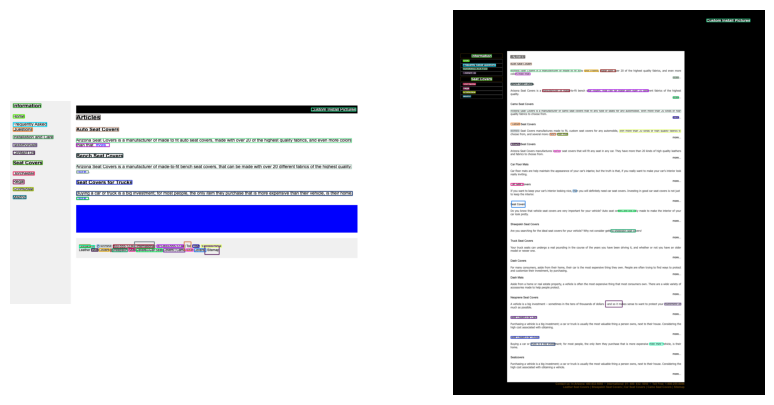

In [132]:
# '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.png'
# visual_eval('./diyi_gpt4.png', './diyi.png')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_side_by_side(img_path1, img_path2):
    """
    Plots two images side by side given their file paths.
    """
    # Load the images
    img1 = mpimg.imread(img_path1)
    img2 = mpimg.imread(img_path2)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the first image in the first subplot
    ax1.imshow(img1)
    ax1.axis('off')  # Turn off axis

    # Display the second image in the second subplot
    ax2.imshow(img2)
    ax2.axis('off')  # Turn off axis

    # Show the plot
    plt.show()

id = 1390
gp4_file = f"/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_{id}.png"
ori_file = f"/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/{id}.png"

visual_eval(gp4_file, ori_file)
plot_images_side_by_side(gp4_file.replace(".png", "_demo.png"), ori_file.replace(".png", "_demo.png"))

# V2: OCR Free

1. Screenshot using playwright: width 1280, height flexible, should be fine.
2. OCR-FREE: detect text pixels by changing the color of texts (identified by tags: ['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'div', 'span', 'a', 'li', 'td', 'th'])

In [133]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [134]:
from bs4 import BeautifulSoup
import random

def rgb_to_hex(rgb):
    """Convert an RGB tuple to hexadecimal format."""
    return '{:02X}{:02X}{:02X}'.format(*rgb)


class ColorPool:
    def __init__(self, offset=0):

        color_values = list(range(10, 251, 16))
        color_list = [((r + offset) % 256, (g + offset) % 256, (b + offset) % 256) for r in color_values for g in color_values for b in color_values]
        self.color_pool = [rgb_to_hex(color) for color in color_list]

    def pop_color(self):
        if self.color_pool:
            return self.color_pool.pop()
        else:
            raise NotImplementedError


def process_html(input_file_path, output_file_path, offset=0):
    # Read the input HTML file
    with open(input_file_path, 'r') as file:
        soup = BeautifulSoup(file, 'html.parser')

    def update_style(element, property_name, value):
        # Update the element's style attribute with the given property and value
        # Adding !important to ensure the style overrides others
        important_value = f"{value} !important"
        styles = element.attrs.get('style', '').split(';')
        updated_styles = [s for s in styles if not s.strip().startswith(property_name) and len(s.strip()) > 0]
        updated_styles.append(f"{property_name}: {important_value}")
        element['style'] = '; '.join(updated_styles).strip()

    # Set the background color of all elements to white
    # for element in soup.find_all(True):
    #     update_style(element, 'background-color', 'white')

    color_pool = ColorPool(offset)

    # Assign a unique color to text within each text-containing element
    text_tags = ['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'div', 'span', 'a', 'li', 'td', 'th']  # Add more tags as needed
    for tag in soup.find_all(text_tags):
        color = f"#{color_pool.pop_color()}"
        update_style(tag, 'color', color)

    # Write the modified HTML to a new file
    with open(output_file_path, 'w') as file:
        file.write(str(soup))

In [135]:
from PIL import Image
def similar(n1, n2):
    if abs(n1 - n2) <= 2:
        return True
    else:
        return False

def find_different_pixels(image1_path, image2_path):
    # Open the images
    img1 = Image.open(image1_path)
    img2 = Image.open(image2_path)

    # Ensure both images are of the same size
    if img1.size != img2.size:
        raise ValueError("Images are not the same size")

    # Convert images to RGB if they are not
    img1 = img1.convert('RGB')
    img2 = img2.convert('RGB')

    # Get pixel data
    pixels1 = img1.load()
    pixels2 = img2.load()

    # List to store coordinates of different pixels
    different_pixels = []

    # Iterate through each pixel
    for x in range(img1.size[0]):
        for y in range(img1.size[1]):
            # Compare pixel colors
            r1, g1, b1 = pixels1[x, y]
            r2, g2, b2 = pixels2[x, y]
            if similar((r1 + 50) % 256, r2) and similar((g1 + 50) % 256, g2) and similar((b1 + 50) % 256, b2):
                different_pixels.append((y, x))

    return np.stack(different_pixels)

In [136]:
from bs4 import BeautifulSoup, NavigableString, Tag, Comment

def extract_text_with_color(html_file):
    def get_color(tag):
        if 'style' in tag.attrs:
            styles = tag['style'].split(';')
            color_style = [s for s in styles if 'color' in s and 'background-color' not in s]
            if color_style:
                return color_style[0].split(':')[1].strip().replace(" !important", "")
        return None

    def extract_text_recursive(element, parent_color='black'):
        if isinstance(element, Comment):
            return None
        elif isinstance(element, NavigableString):
            text = element.strip()
            return (text, parent_color) if text else None

        elif isinstance(element, Tag):
            current_color = get_color(element) or parent_color
            children_texts = filter(None, [extract_text_recursive(child, current_color) for child in element.children])
            return list(children_texts)

    with open(html_file, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'lxml')
        body = soup.body
        return extract_text_recursive(body) if body else []


def flatten_tree(tree):
    flat_list = []

    # Helper function to recursively flatten the tree
    def flatten(node):
        if isinstance(node, list):
            for item in node:
                flatten(item)
        else:
            flat_list.append(node)

    # Flatten the tree
    flatten(tree)
    return flat_list

In [137]:
def get_blocks_from_image_diff_pixels(image_path, html_text_color_tree, different_pixels):
    image = cv2.imread(image_path)
    x_w = image.shape[0]
    y_w = image.shape[1]

    def hex_to_bgr(hex_color):
        """
        Converts a hex color string to a BGR color tuple.
        """
        hex_color = hex_color.lstrip('#')
        rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return rgb[::-1]


    def get_intersect(arr1, arr2):
        # Reshape the arrays to 1D
        arr1_reshaped = arr1.view([('', arr1.dtype)] * arr1.shape[1])
        arr2_reshaped = arr2.view([('', arr2.dtype)] * arr2.shape[1])

        # Find the intersection
        common_rows = np.intersect1d(arr1_reshaped, arr2_reshaped)

        # Reshape the result back to 2D, if needed
        common_rows = common_rows.view(arr1.dtype).reshape(-1, arr1.shape[1])
        return common_rows


    blocks = []
    for item in html_text_color_tree:
        color = np.array(hex_to_bgr(item[1]), dtype="uint8")
        lower = color - 2
        upper = color + 2

        mask = cv2.inRange(image, lower, upper)

        coords = np.column_stack(np.where(mask > 0))

        coords = get_intersect(coords, different_pixels)

        if coords.size == 0:
            continue

        x_min, y_min = np.min(coords, axis=0)
        x_max, y_max = np.max(coords, axis=0)

        blocks.append({'text': item[0], 'bbox': (y_min / y_w, x_min / x_w, (y_max - y_min) / y_w, (x_max - x_min) / x_w)})
    
    return blocks

In [138]:
def get_itermediate_names(name):
    return name.replace(".png", ".html"), name.replace(".png", "_p.html"), name.replace(".png", "_p_1.html"), name.replace(".png", "_p.png"), name.replace(".png", "_p_1.png")

def get_blocks_ocr_free(image_path):
    html, p_html, p_html_1, p_png, p_png_1 = get_itermediate_names(image_path)
    process_html(html, p_html)
    process_html(html, p_html_1, offset=50)

    os.system(f"python3 screenshot_single.py --html {p_html} --png {p_png}")
    os.system(f"python3 screenshot_single.py --html {p_html_1} --png {p_png_1}")

    different_pixels = find_different_pixels(p_png, p_png_1)
    html_text_color_tree = flatten_tree(extract_text_with_color(p_html))
    blocks = get_blocks_from_image_diff_pixels(p_png, html_text_color_tree, different_pixels)
    os.system(f"rm {p_html} {p_png} {p_html_1} {p_png_1}")
    return blocks

blocks1 = get_blocks_ocr_free("/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.png")
blocks2 = get_blocks_ocr_free("/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390.png")

Saved to /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390_p.png
Saved to /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390_p_1.png
Saved to /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390_p.png
Saved to /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390_p_1.png


In [139]:
print(blocks1)
print(blocks2)

[{'text': 'Information', 'bbox': (0.060495626822157436, 0.1154299175500589, 0.061224489795918366, 0.006478209658421673)}, {'text': 'Home', 'bbox': (0.03279883381924198, 0.13015312131919907, 0.01967930029154519, 0.0035335689045936395)}, {'text': 'Frequently Asked Questions', 'bbox': (0.03279883381924198, 0.14075382803297998, 0.10276967930029154, 0.004711425206124852)}, {'text': 'Installation And Care', 'bbox': (0.03279883381924198, 0.1513545347467609, 0.07507288629737609, 0.0035335689045936395)}, {'text': 'Contact Us', 'bbox': (0.03279883381924198, 0.16195524146054183, 0.038629737609329445, 0.0035335689045936395)}, {'text': 'Seat Covers', 'bbox': (0.05830903790087463, 0.17550058892815076, 0.06486880466472303, 0.006478209658421673)}, {'text': 'Dorchester', 'bbox': (0.03279883381924198, 0.19081272084805653, 0.038629737609329445, 0.0035335689045936395)}, {'text': 'Regal', 'bbox': (0.03279883381924198, 0.20141342756183744, 0.018950437317784258, 0.004711425206124852)}, {'text': 'Scottsdale',

In [140]:
def visual_eval(gpt_img, original_img):
    blocks1 = get_blocks_ocr_free(gpt_img)
    blocks2 = get_blocks_ocr_free(original_img)

    print(len(blocks1), blocks1)
    print(len(blocks2), blocks2)

    matching = find_maximum_matching(blocks1, blocks2, 0.1, 1)
    matched_list = []
    print("Matching pairs:")
    location_score = []
    size_score = []
    for i, j in matching:
        print(f"{blocks1[i]} matched with {blocks2[j]}")
        matched_list.append([blocks1[i]['bbox'], blocks2[j]['bbox']])
        location_score.append(calculate_distance(blocks1[i]['bbox'][0] + blocks1[i]['bbox'][2], \
                                                blocks1[i]['bbox'][1] + blocks1[i]['bbox'][3], \
                                                blocks2[j]['bbox'][0] + blocks2[j]['bbox'][2], \
                                                blocks2[j]['bbox'][1] + blocks2[j]['bbox'][3]))
        assert calculate_ratio(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2]) > 0 and calculate_ratio(blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]) > 0, f"{blocks1[i]} matched with {blocks2[j]}"
        size_score.append(calculate_ratio(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2]) * calculate_ratio(blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]))
    print(f"Matched: {len(location_score)}")
    print("Location Score:")
    print_stat(location_score)
    print("Size Score:")
    print_stat_geo(size_score)

    img1 = cv2.imread(gpt_img)
    img2 = cv2.imread(original_img)

    img1_with_boxes, img2_with_boxes = draw_matched_bboxes(img1, img2, matched_list)

    cv2.imwrite(gpt_img.replace(".png", "_demo.png"), img1_with_boxes)
    cv2.imwrite(original_img.replace(".png", "_demo.png"), img2_with_boxes)

    if len(location_score) > 0:
        return len(location_score), np.mean(location_score), geo_mean(size_score)
    else:
        return 0.0, None, None

Saved to /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390_p.png
Saved to /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390_p_1.png
Saved to /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390_p.png
Saved to /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390_p_1.png
24 [{'text': 'Information', 'bbox': (0.009375, 0.01891891891891892, 0.0765625, 0.016216216216216217)}, {'text': 'Home', 'bbox': (0.009375, 0.07162162162162163, 0.03046875, 0.014864864864864866)}, {'text': 'Frequently Asked Questions', 'bbox': (0.00859375, 0.10945945945945947, 0.09375, 0.04054054054054054)}, {'text': 'Installation and Care', 'bbox': (0.009375, 0.17297297297297298, 0.11171875, 0.014864864864864866)}, {'text': 'Testimonials', 'bbox': (0.00859375, 0.21216216216216216, 0.06640625, 0.014864864864864866)}, {'text': 'Contact Us', 'bbox': (0.00859375, 0.25, 0.059375, 0.014864864864864866)}, {'text': 'Seat Covers', 'bbox': (0.00859375, 0.298648648648648

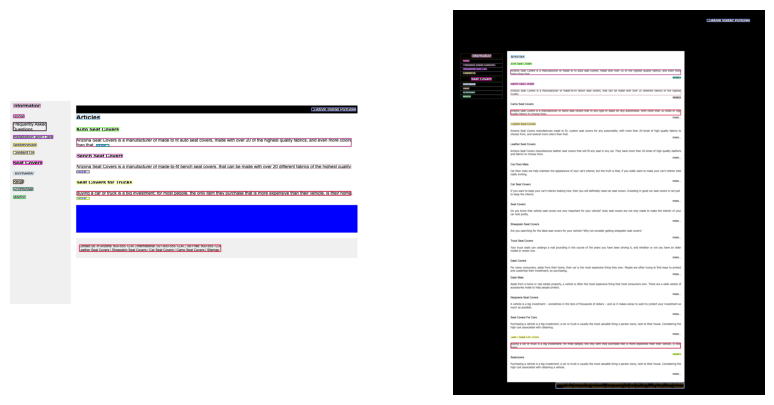

In [141]:
# '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.png'
# visual_eval('./diyi_gpt4.png', './diyi.png')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_side_by_side(img_path1, img_path2):
    """
    Plots two images side by side given their file paths.
    """
    # Load the images
    img1 = mpimg.imread(img_path1)
    img2 = mpimg.imread(img_path2)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the first image in the first subplot
    ax1.imshow(img1)
    ax1.axis('off')  # Turn off axis

    # Display the second image in the second subplot
    ax2.imshow(img2)
    ax2.axis('off')  # Turn off axis

    # Show the plot
    plt.show()

id = 1390
gp4_file = f"/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_{id}.png"
ori_file = f"/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/{id}.png"

visual_eval(gp4_file, ori_file)
plot_images_side_by_side(gp4_file.replace(".png", "_demo.png"), ori_file.replace(".png", "_demo.png"))

# TODO: Fix matching issues

1. Currently only support 1-to-1 matching
2. Maybe we can consider affine transformation before matching.


In [26]:
from html2image import Html2Image
# hti = Html2Image(custom_flags=['--default-background-color=FFFFFF', '--hide-scrollbars'])
hti = Html2Image(custom_flags=['--default-background-color=000000', '--hide-scrollbars'])
hti.output_path = "/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/"

hti.screenshot(
    html_file = "/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.html",
    save_as = "1390.png",
    size=(1920, 1920)
)

hti.screenshot(
    html_file = "/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390.html",
    save_as = "gpt4v_1390.png",
    size=(1920, 1920)
)

[1126/215220.077298:WARNING:angle_platform_impl.cc(49)] RendererVk.cpp:1962 (initialize): ANGLE VMA version: 2003000
608643 bytes written to file /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.png
[1126/215221.771202:WARNING:angle_platform_impl.cc(49)] RendererVk.cpp:1962 (initialize): ANGLE VMA version: 2003000
167247 bytes written to file /Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390.png


['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390.png']

In [34]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def rescale_short_edge_to_long_edge(image_path):
    # Load the image
    with Image.open(image_path) as img:
        width, height = img.size

        # Determine which side is shorter
        if width < height:
            # Width is shorter, scale height to match the width
            new_size = (width, width)
        else:
            # Height is shorter, scale width to match the height
            new_size = (height, height)

        # Resize the image while maintaining aspect ratio
        img_resized = img.resize(new_size, Image.ANTIALIAS)

        return img_resized

def calculate_clip_similarity(image_path1, image_path2):
    # Load and preprocess images
    image1 = preprocess(rescale_short_edge_to_long_edge(image_path1)).unsqueeze(0).to(device)
    image2 = preprocess(rescale_short_edge_to_long_edge(image_path2)).unsqueeze(0).to(device)

    # Calculate features
    with torch.no_grad():
        image_features1 = model.encode_image(image1)
        image_features2 = model.encode_image(image2)

    # Normalize features
    image_features1 /= image_features1.norm(dim=-1, keepdim=True)
    image_features2 /= image_features2.norm(dim=-1, keepdim=True)

    # Calculate cosine similarity
    similarity = (image_features1 @ image_features2.T).item()

    return similarity

# Example usage
similarity = calculate_clip_similarity('/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390.png')
print(similarity)
similarity = calculate_clip_similarity('/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.png')
print(similarity)

0.8859788179397583
1.000000238418579


In [1]:
import os

import sys
from pathlib import Path

wd = "../"
sys.path.append(str(wd))

from visual_score import visual_eval

res_list = []
no_match = []
folder_name = "/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset"
cnt = 0
for filename in os.listdir(folder_name):
    if filename.endswith(".png") and os.path.exists(os.path.join(folder_name, "gpt4v_" + filename)) and filename.replace(".png", "").isnumeric():
        cnt += 1
        if cnt > 5:
            # break
            pass

        print("-------------------------------------")
        print(f"Evaluating... {filename}")
        matched, mean_loc_score, mean_size_score, _ = visual_eval(os.path.join(folder_name, "gpt4v_" + filename), os.path.join(folder_name, filename), True)
        if matched > 0:
            res_list.append([os.path.join(folder_name, "gpt4v_" + filename), os.path.join(folder_name, filename), matched, mean_loc_score, mean_size_score])
        else:
            print(f"No matched point for {filename}")
            no_match.append([os.path.join(folder_name, "gpt4v_" + filename), os.path.join(folder_name, filename)])

/Users/zhangyanzhe/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


-------------------------------------
Evaluating... 1390.png
Matched: 24
Location Score:
Mean: 0.23213821929815034 Median: 0.20316914941788106 Min: 0.033592656121179065 Max: 0.6494222580953048
Size Score:
Geo Mean: 4.341498540440297 Median: 4.961805137488923 Min: 1.9597444054054052 Max: 8.653344282286769
-------------------------------------
Evaluating... 3544.png
Matched: 17
Location Score:
Mean: 0.45336384857151263 Median: 0.539557365806074 Min: 0.08932341092106838 Max: 0.792405702616778
Size Score:
Geo Mean: 7.347006052996277 Median: 16.06885264451054 Min: 1.1005627520879167 Max: 74.54996511164275
-------------------------------------
Evaluating... 4377.png
Matched: 12
Location Score:
Mean: 0.7269625352010117 Median: 0.714883308781173 Min: 0.6046291784912171 Max: 1.029158890577206
Size Score:
Geo Mean: 4.161585901902593 Median: 1.5990593238315403 Min: 1.2981220657276995 Max: 1190.2916666666667
-------------------------------------
Evaluating... 1795.png
Matched: 15
Location Score:
M

In [2]:
for item in no_match:
    print(item)

In [3]:
print(len(res_list))

102


In [4]:
import pickle
with open('res_list.pkl', 'wb') as f:
    pickle.dump(res_list, f)

In [5]:
import pickle
with open('res_list.pkl', 'rb') as f:
    res_list = pickle.load(f)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_side_by_side(img_path1, img_path2):
    """
    Plots two images side by side given their file paths.
    """
    # Load the images
    img1 = mpimg.imread(img_path1)
    img2 = mpimg.imread(img_path2)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the first image in the first subplot
    ax1.imshow(img1)
    ax1.axis('off')  # Turn off axis

    # Display the second image in the second subplot
    ax2.imshow(img2)
    ax2.axis('off')  # Turn off axis

    # Show the plot
    plt.show()

def print_percentiles(sorted_list):
    n = len(sorted_list)
    percentiles = [int(p/100 * (n-1)) for p in range(0, 101, 10)]

    for p in percentiles:
        print(f"{p*100/(n-1):.0f}%: {sorted_list[p]}")
        plot_images_side_by_side(sorted_list[p][0].replace(".png", "_demo.png"), sorted_list[p][1].replace(".png", "_demo.png"))


0%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4188.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4188.png', 1, 0.06854589028203179, 5.556627170019288]


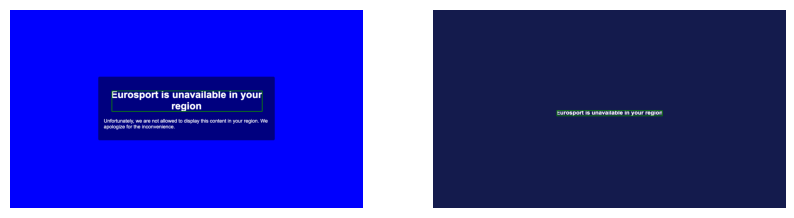

10%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_896.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/896.png', 5, 0.1492453344999881, 1.8834230105560994]


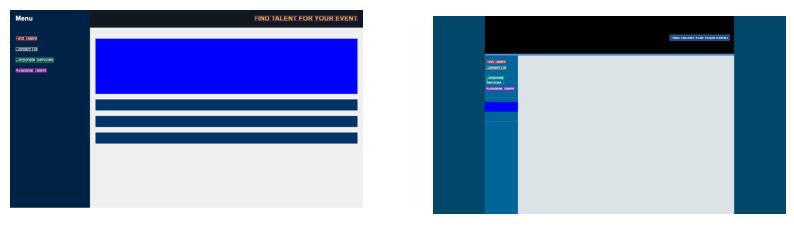

20%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1720.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1720.png', 31, 0.20491907057175873, 1.8049381945633611]


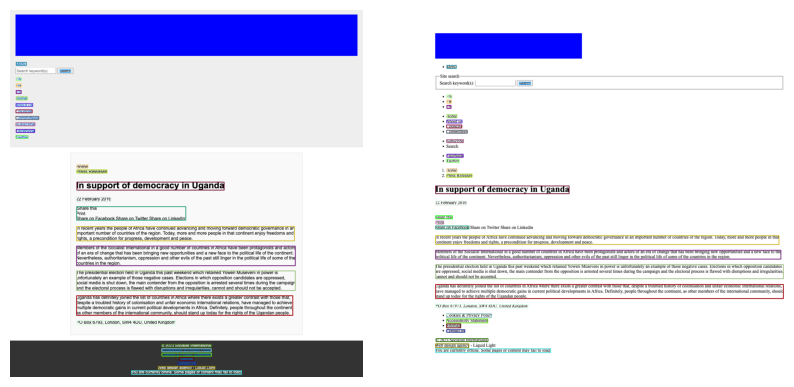

30%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1390.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1390.png', 24, 0.23213821929815034, 4.341498540440297]


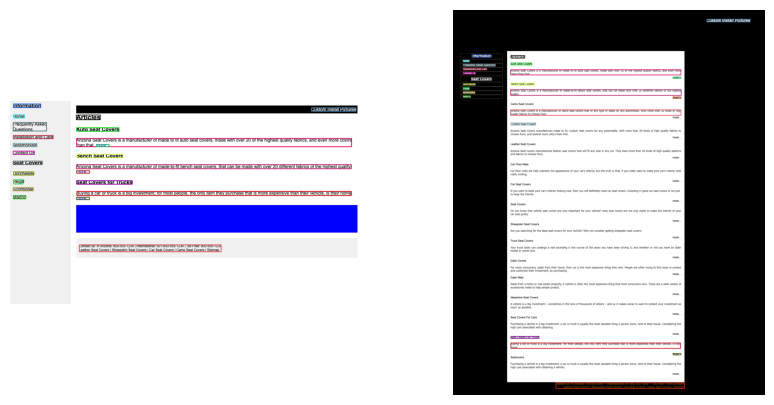

40%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3876.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3876.png', 17, 0.2515301728899109, 2.947137190739679]


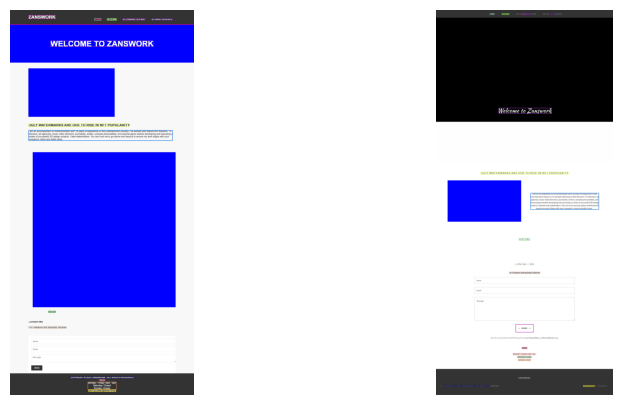

50%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_711.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/711.png', 22, 0.27281746491248976, 5.248473100455441]


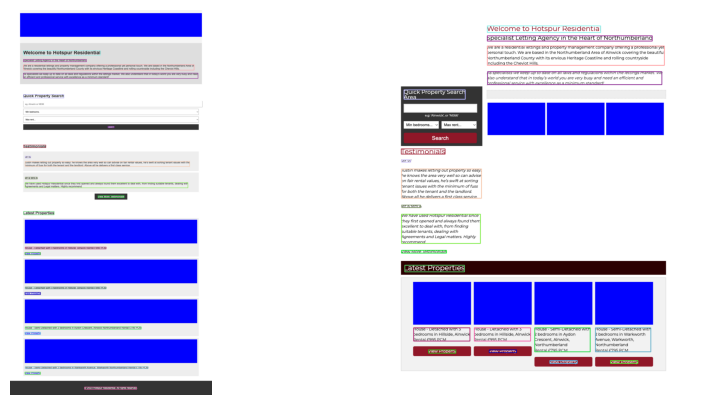

59%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4041.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4041.png', 20, 0.29715106511885603, 8.497956257119293]


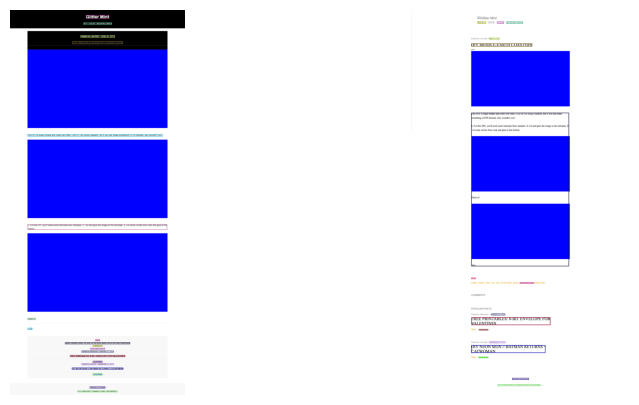

69%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_967.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/967.png', 19, 0.3261429727561149, 7.144600451918198]


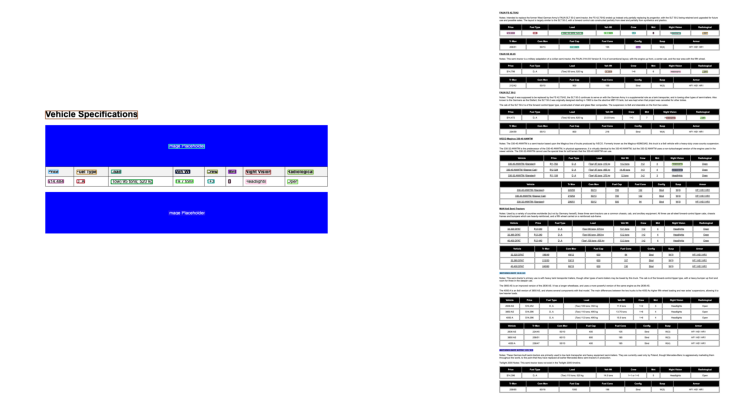

79%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3679.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3679.png', 6, 0.3782256154536679, 1.4377968892838473]


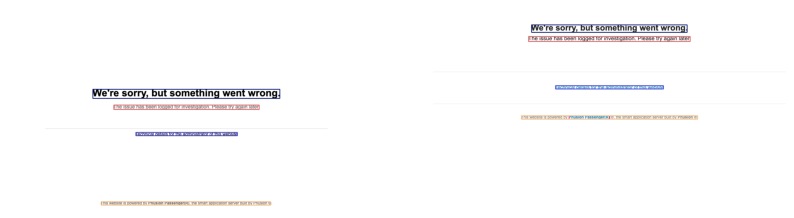

89%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3090.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3090.png', 15, 0.4253078627945576, 2.8143242124659227]


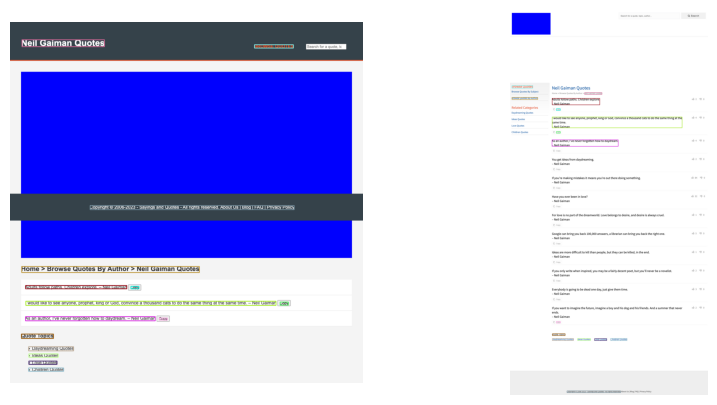

100%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4377.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4377.png', 12, 0.7269625352010117, 4.161585901902593]


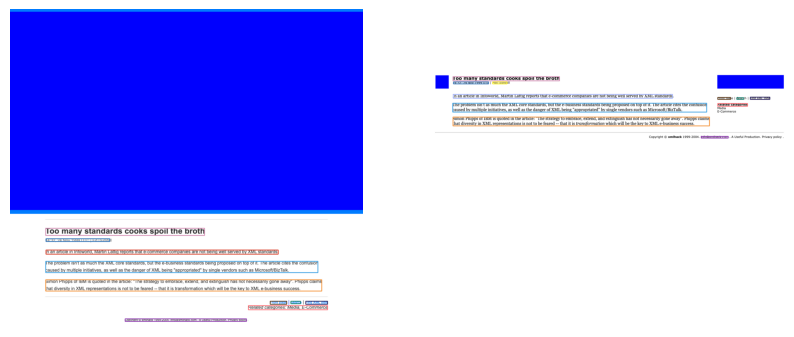

In [7]:
# Rank by location score
res_list = sorted(res_list, key=lambda tup: tup[-2])
print_percentiles(res_list)

0%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1584.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1584.png', 2, 0.3143263686945164, 1.2442795266670628]


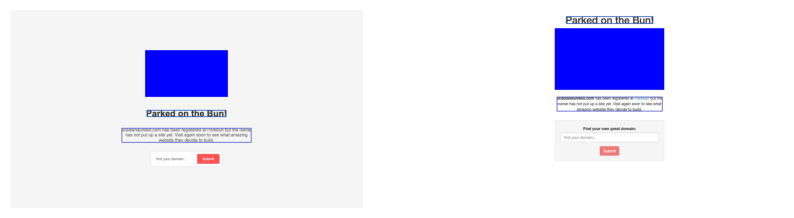

10%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1422.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1422.png', 29, 0.26171881493318866, 1.8186309038810018]


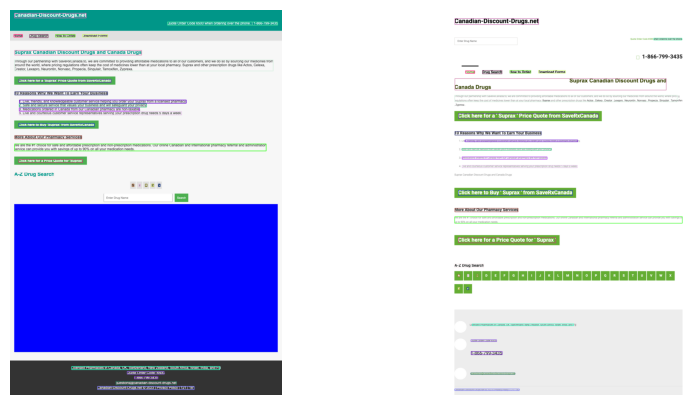

20%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1189.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1189.png', 30, 0.270684596388485, 1.988140013241507]


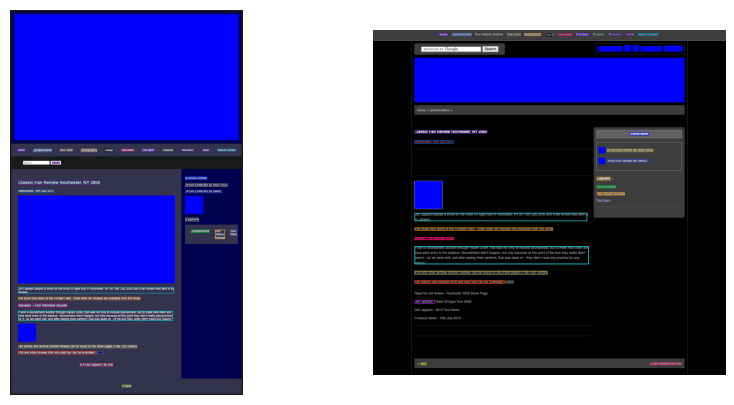

30%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1391.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1391.png', 40, 0.2698873833980388, 2.341353679364821]


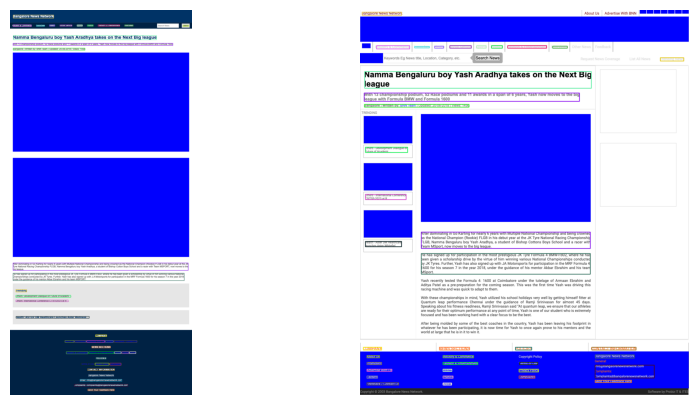

40%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3876.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3876.png', 17, 0.2515301728899109, 2.947137190739679]


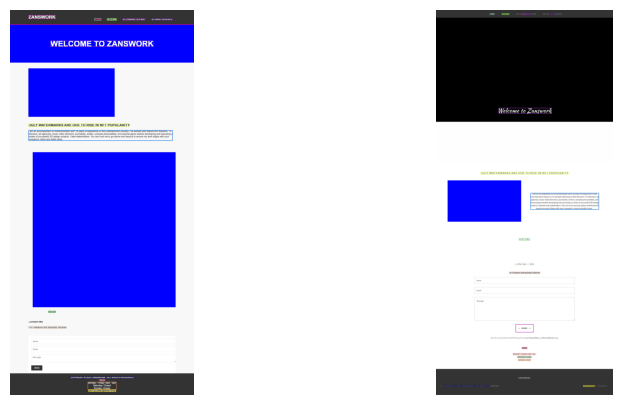

50%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1550.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1550.png', 9, 0.23029511133368358, 3.4042528179116105]


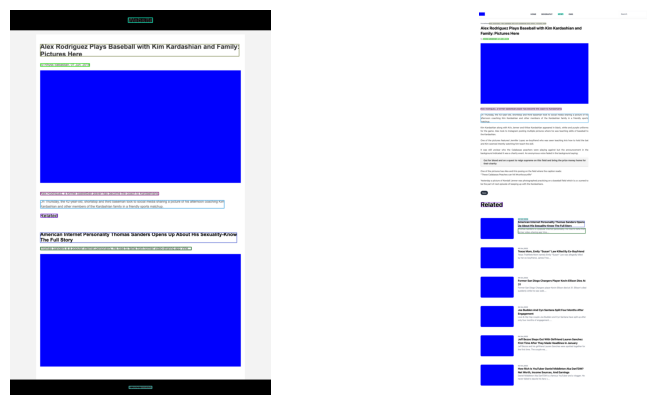

59%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3273.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3273.png', 19, 0.4326848917866618, 4.076661228074172]


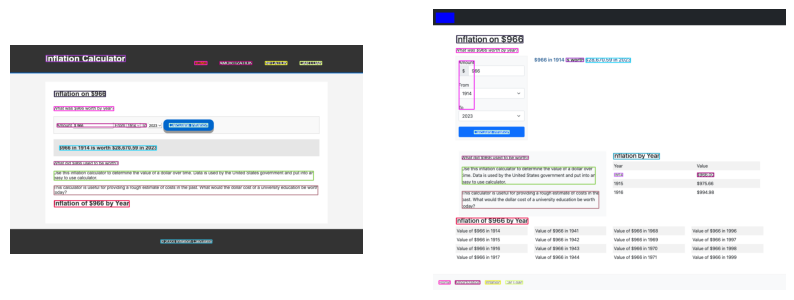

69%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_809.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/809.png', 6, 0.37292767373100405, 4.710536676962681]


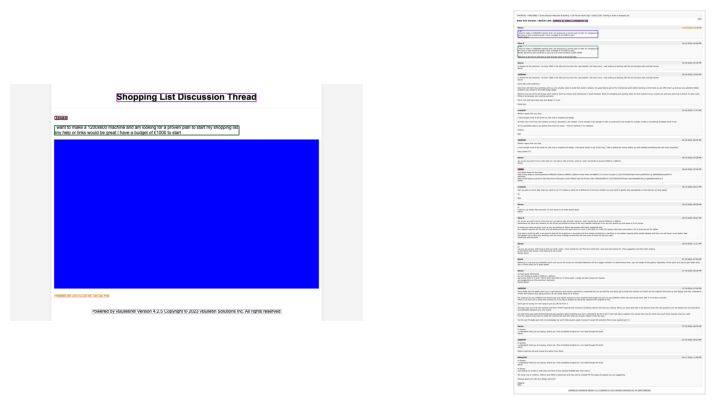

79%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_4188.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/4188.png', 1, 0.06854589028203179, 5.556627170019288]


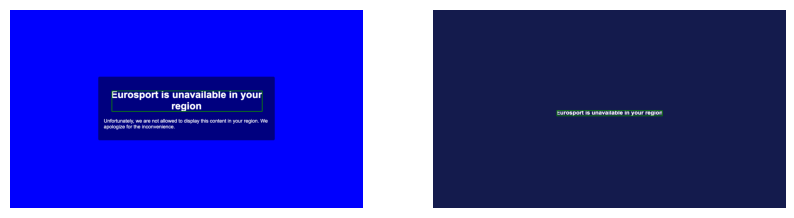

89%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_3544.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/3544.png', 17, 0.45336384857151263, 7.347006052996277]


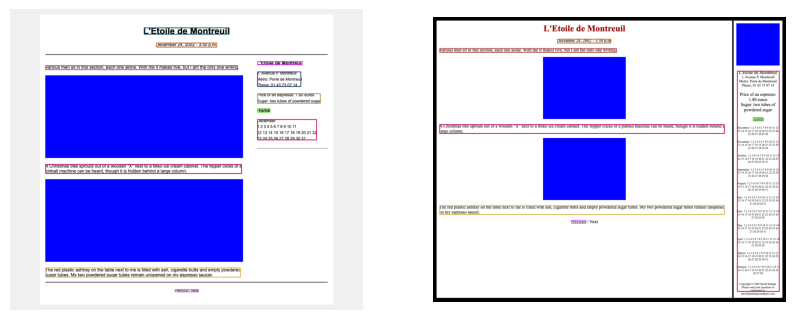

100%: ['/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/gpt4v_1808.png', '/Users/zhangyanzhe/Documents/GitHub/Pix2Code/pilot_testset/1808.png', 6, 0.687260267903084, 50.34936638719604]


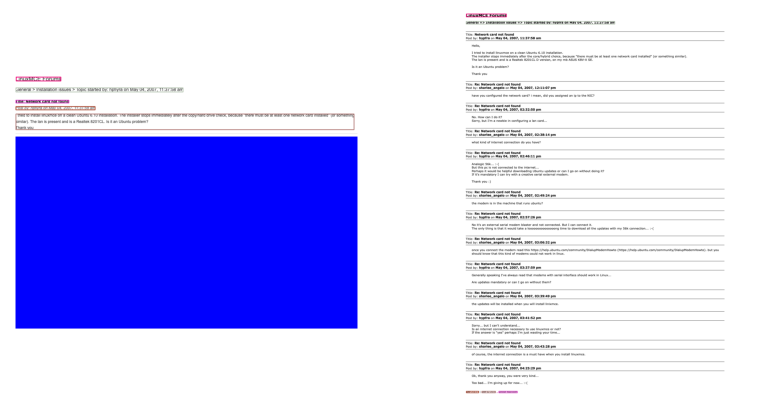

In [8]:
# Rank by size score
res_list = sorted(res_list, key=lambda tup: tup[-1])
print_percentiles(res_list)